In [ ]:
#%pip install -U langchain-tavily
# https://langchain-ai.github.io/langgraph/tutorials/get-started/2-add-tools/#5-create-a-function-to-run-the-tools

# add-tool

In [17]:
import dotenv
dotenv.load_dotenv()
import os
if os.environ["TAVILY_API_KEY"]:
    print("TAVILY_API_KEY OK!")
if os.environ["DEEPSEEK_API_KEY"]:
    print("DEEPSEEK_API_KEY OK!")

TAVILY_API_KEY OK!
DEEPSEEK_API_KEY OK!


In [8]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent‚Äôs state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-ma

In [18]:
import os

from langchain.chat_models import init_chat_model

llm = init_chat_model("deepseek-chat", model_provider="deepseek")



In [19]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [20]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [21]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

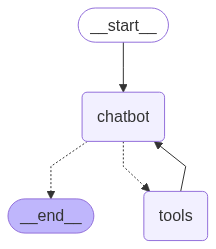

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: ÊàëÈúÄË¶ÅÁü•ÈÅìÊÇ®ÊâÄÂú®ÁöÑÂÖ∑‰Ωì‰ΩçÁΩÆÊâçËÉΩÊü•ËØ¢‰ªäÂ§©ÁöÑÂ§©Ê∞îÊÉÖÂÜµ„ÄÇËØ∑ÂëäËØâÊàëÊÇ®ÊÉ≥Êü•ËØ¢Âì™‰∏™ÂüéÂ∏ÇÁöÑÂ§©Ê∞îÔºü
Assistant: ÊàëÊù•Â∏ÆÊÇ®Êü•ËØ¢Ë¥µÈò≥Â∏ÇÁöÑÂ§©Ê∞îÊÉÖÂÜµ„ÄÇ
Assistant: {"query": "\u8d35\u9633\u5e02\u5929\u6c14\u9884\u62a5", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://m.weather.com.cn/mweather15d/101260101.shtml", "title": "\u8d35\u9633\u5929\u6c14\u9884\u62a515\u5929\u67e5\u8be2", "content": "8~15\u00e5\u00a4\u00a9\u00e5\u00a4\u00a9\u00e6\u00b0\u0094\u00e9\u00a2\u0084\u00e6\u008a\u00a5\u00ef\u00bc\u008c\u00e6\u0098\u00af\u00e9\u009b\u0086\u00e5\u0090\u0088\u00e5\u00a4\u009a\u00e5\u00ae\u00b6\u00e5\u0085\u00a8\u00e7\u0090\u0083\u00e6\u0095\u00b0\u00e5\u0080\u00bc\u00e5\u00a4\u00a9\u00e6\u00b0\u0094\u00e9\u00a2\u0084\u00e6\u008a\u00a5\u00e6\u00a8\u00a1\u00e5\u00bc\u008f\u00e5\u00ae\u00a2\u00e8\u00a7\u0082\u00e9\u00a2\u0084\u00e6\u008a\u00a5\u00e4\u00ba\u00a7\u00e5\u0093\u0081\u00e5\u008a \u00e5\u00b7\u00a5\u00

In [ ]:
import os

from langchain.chat_models import init_chat_model

llm = init_chat_model("deepseek-chat", model_provider="deepseek")

from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

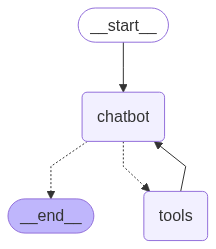

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# add memory

In [3]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

In [4]:
graph = graph_builder.compile(checkpointer=memory)

In [5]:
config = {"configurable": {"thread_id": "1"}}

In [6]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! Nice to meet you. I'm here to help you with any questions or tasks you might have. Whether you need information, research assistance, or help with various topics, feel free to ask! What can I do for you today?


In [8]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, Will! I remember that you introduced yourself as Will at the beginning of our conversation. It's nice to chat with you! 

However, I should note that I don't have persistent memory between conversations, so if you start a new chat session later, I won't remember this interaction or your name unless you tell me again.

What would you like to talk about or work on today, Will?


In [ ]:
user_input = "Remember my name?"
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! Nice to meet you. I'm here to help you with any questions or tasks you might have. Whether you need information, research assistance, or just want to chat, feel free to ask! What can I do for you today?


In [9]:
user_input = "Remember my name?"
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "1"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, Will! I remember that you told me your name is Will at the beginning of our conversation. You're the same person I've been chatting with in this session.

As I mentioned before, while I can remember details within our current conversation, I don't have persistent memory between different chat sessions. So if you start a new conversation later, I won't automatically remember that your name is Will unless you tell me again.

Is there something specific you'd like to discuss or work on, Will?


In [10]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='3818a654-acc8-4fa6-89a0-835202949f79'), AIMessage(content="Hi Will! Nice to meet you. I'm here to help you with any questions or tasks you might have. Whether you need information, research assistance, or help with various topics, feel free to ask! What can I do for you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 1806, 'total_tokens': 1856, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 1792}, 'prompt_cache_hit_tokens': 1792, 'prompt_cache_miss_tokens': 14}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_feb633d1f5_prod0820_fp8_kvcache', 'id': '417737d8-21f8-4b16-9353-7ae2981e94c9', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--67f3b7e6-c897-4520-88f3-bf3847315100-0', usage_metadata={'i

# human in the loop

In [11]:
# human in the loop
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")